# 1. Getting started with ReNetA

Authors: **Gorka Zamora-López** and **Matthieu Gilson**

<br/>


---------------------

This notebook is an introductory tutorial for the use of *Response Network Analysis* to study complex networks.

#### Outline
* DynComFlow library installation.
* Overview of basic concepts. 
* Example-1: Path graphs.
* Example-2: Ring-lattice and randomization.

--------------------

### Dependencies

The tutorial requires a Python 3.X installation together with NumPy and Matplotlib libraries. It also requires further in-house modules. [GAlib](https://github.com/gorkazl/pyGAlib) is a generic library for graph analysis. [ReNetA](https://github.com/mb-BCA/ReNetA) to estimate and study pair-wise network responses.


#### Import the main libraries

To get started, the first thing we need is to load the libraries we will need to work. Start importing the built-in and third party libraries.



In [1]:
# Python standard library imports
# Third party imports
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import numpy.linalg


#### Import personal libraries

The following cells will check whether *GAlib* and *ReNetA* are already installed in the current working environment, otherwise, `pip` will be called for the installation (a working internet connection is required). **NOTE**: The exclamation mark ( ! ) before ``pip install galib`` indicates the Jupyter Notebook that the current line is a system command, which is then treated as if it were run from a terminal.


In [2]:
## Check if GAlib is installed in the current environment, otherwise install
try:
    import galib
except:
    # Install from PyPI
    print('Installing GAlib...')
    ! pip install galib
    import galib

In [3]:
import galib.models
import galib.tools

In [4]:
## Check if NetDynFlow is installed in the current environment, otherwise install
try:
    import reneta
except:
    # Install from the GitHub repository
    print('Installing NetDynFlow...')
    ! pip install git+https://github.com/mb-BCA/ReNetA.git@master

import reneta as rna

In [4]:
# Explore the help functions of ReNetA
# rna?
# rna.responses?
# rna.metrics?

<br/>

## Overview of basic concepts

The aim of *Response Network Analysis* is to study and to characterise complex networks overcoming limitations of graph theory, specially concerning the study of weighted and directed networks. We characterise the structure by observing how perturbations (stimuli of unit amplitude) propagate along a network. To do so, we need to assume a dynamic model on the network governing that propagation. For these preliminary examples we assume the nodes dynamics to be governed by the continuous leaky cascade model. Given that $A$ is the connectivity matrix (weighted or unweighted, directed or undirected) the dynamics of a node follows: 

$ \dot{x}_i = - \frac{x_i}{\tau} + \sum_{j=1}^N x_j $

where $\tau$ is the leakage time-constant. The role of $\tau$ is to control the rate of leakage through the nodes, thus counter-balancing the tendency of the linear connectivity to cause the divergence of the system.

The pair-wise responses $R_{ij}(t)$ qunatify the effect of a stimulus on (source) node $i$, applied at $t=0$, has on (target) node $j$ at time $t$.

<!-- Thus, dynamic communicability quantifies the network response to a unit stimulus (via the Green function). The following examples will emphasize a few basic properties: 

- Dynamic communicability captures the evolution of the global network feedback over (integration) time.
- Node-wise input and output communicabilities capture the listening and broadcasting nature of nodes.
- Two nodes without a direct connection use to have non-zero interactions due to the network effects.
- Along integration time the dynamic communicability matrix is first dominated by node weights, then by network feedback and finally it becomes homogeneous.

-->

<br/>

## Example 1: First steps,  path (di)graphs

### Pair-wise responses
We start by studying the notions of *Response Network Analysis* on very simple graphs. Consider a chain graphs as the one with directed arcs in the figure below. We will characterise how a perturbation applied to the first node propagates along the chain.

<img src="Images/PathGraph_Directed1.png" style="float:center; width:500px; height:50px"  alt="Path Graph" />


In this first example we will: 
1. Create the digraph, 
2. calculate its spectral diameter to estimate the largest time-constant $\tau_{max}$ acceptable,
3. apply a perturbation at the first node,
4. explore subsequent responses in other nodes over time, and 
5. visualise the node-wise input and output responses.

In [5]:
# Create a directed path graph of N = 6 nodes
N = 6
dirnet = galib.models.PathGraph(N, directed=True)

# Find the spectral radius and the largest time constant 
evs = numpy.linalg.eigvals(dirnet)
evsnorms = np.zeros(N, float)
for i in range(N):
    evsnorms[i] = numpy.linalg.norm(evs[i])
evmax = evsnorms.max()
maxtau = 1./evmax

print( 'Spectral radius:\t%2.5f' %evmax )
print( 'Largest possible tau:\t%2.5f' %maxtau )

Spectral radius:	0.00000
Largest possible tau:	inf


/var/folders/n7/dqfcq8pj0g33r_vcx01n6jdm0000gn/T/ipykernel_25134/1026583921.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  maxtau = 1./evmax


For a given network represented by $A$, the tendency of the network dynamics to diverge is represented by the largest eigenvalue (spectral radious) $\lambda_{max}$ of $A$. To assure the convergence of the system the leakage along each node needs to counterbalance this tendency. For that, the condicion $\tau < \tau_{max}$ with $\tau_{max} = 1 \,/\, \lambda_{max}$ needs to be fulfilled. 
In this particular case, all the eigenvalues of the directed path graph are zero, thus, $\tau_{max} = \infty$ and the system converges for any value of $\tau$. But this will not be the case in general.

We now define an _**external perturbation**_, which is encoded in the `stimvec` array, containing the amplitude on the initial stimuli at each node. In this case, we assume an stimulus of unit amplitude, only at the first node.

In [33]:
# Set the matrix of noisy inputs
stimvec = np.zeros(N)
stimvec[0] = 1.0

# Set a leakage time-constant
tau = 1.0

# Define the temporal resolution for the "simulation"
tfinal = 10
dt = 0.01
tpoints = np.arange(0.0, tfinal+dt, dt)
nsteps = len(tpoints)

# Calculate the pair-wise responses for a time span between 0 and tmax
resps_dir = rna.Resp_LeakyCascade(dirnet, S0=stimvec, tau=tau, tmax=tfinal, timestep=dt, case='full') 

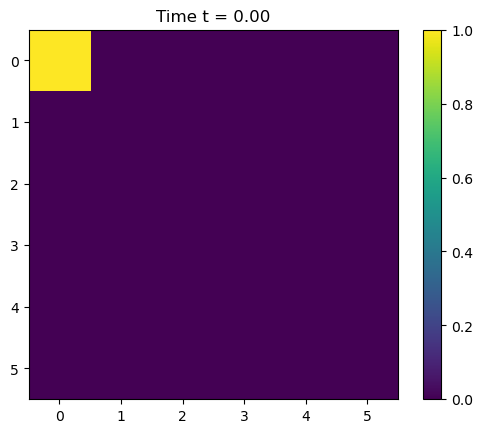

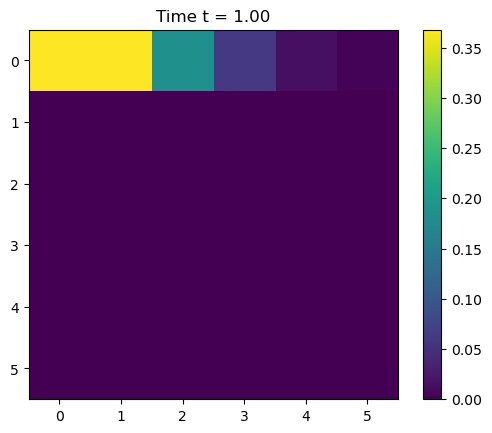

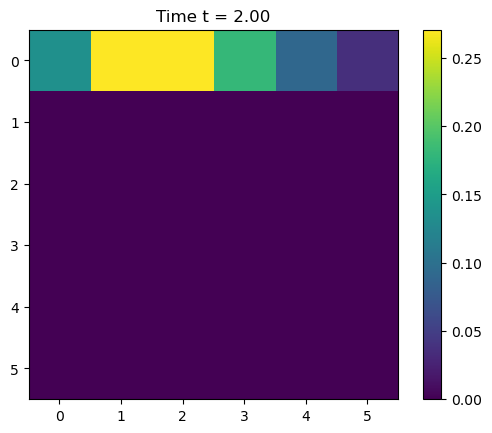

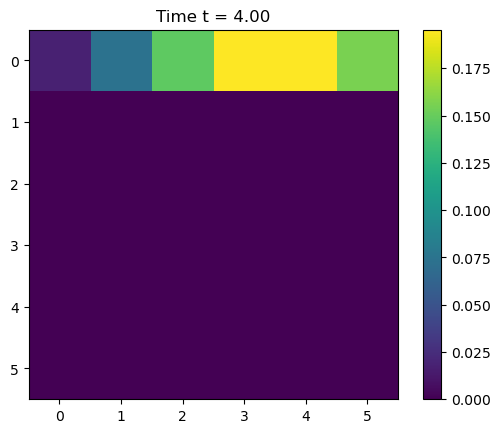

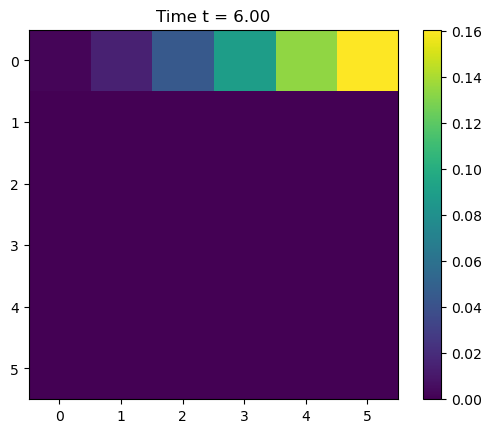

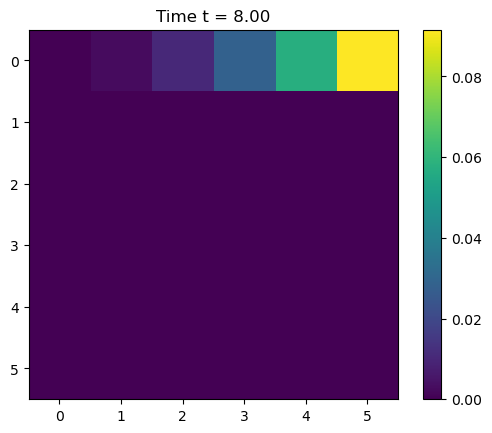

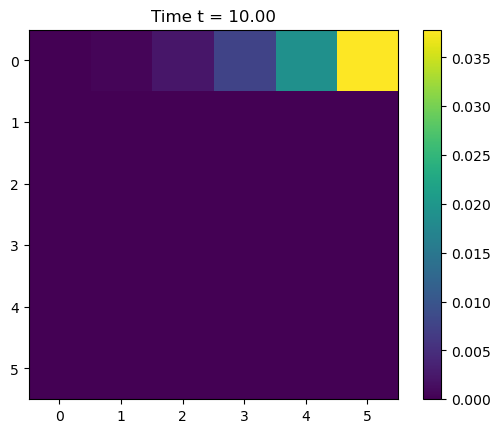

In [34]:
# Visualise the flow matrices at different times
tlist = [0, 100, 200, 400, 600, 800, 1000]
for tidx in tlist:
    plt.figure()
    plt.title('Time t = %2.2f' %(tidx*dt) )
    plt.imshow(resps_dir[tidx])
    plt.colorbar()


As seen, the effect of the stimulus initially applied at the first node affects other nodes down the chain at different times. We visualize this more explicitely, computing the input and output responses of every node over time.

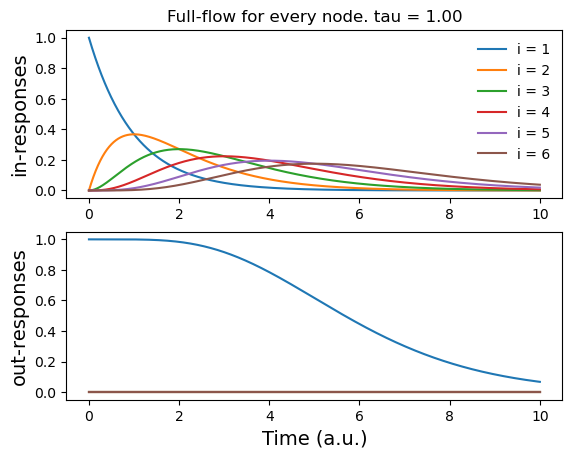

In [39]:
# Calculate the in-/out- full-flow for every node
# infullflow and outfullflow are two arrays of shape (N,nsteps)
inresp_dir, outresp_dir = rna.NodeResponses(resps_dir, selfloops=True)

# Plot a figure wit the input and output responses of every node
plt.figure()
plt.subplot(2,1,1)
plt.title('Full-flow for every node. tau = %1.2f' %tau, fontsize=12)
for i in range(N):
    plt.plot(tpoints, inresp_dir[:,i], label='i = %d' %(i+1))
#plt.ylim(-0.005,0.1)
plt.ylabel('in-responses', fontsize=14);
plt.legend(frameon=False)

plt.subplot(2,1,2)
for i in range(N):
    plt.plot(tpoints, outresp_dir[:,i], label='i = %d' %(i+1))
plt.ylabel('out-responses', fontsize=14);
plt.xlabel('Time (a.u.)', fontsize=14);

<br/>

## Example 2: Defining distance between nodes

In a graph, the distance between two nodes is defined as the number of links needed to cross, to travel from one node to another. However, this definition of distance has no general equivalence for weighted networks since the notion of a "weighted jump" does not have a meaning. From the dynamical perspective, however, the distance between two nodes can be defined as the time it takes for the stimulus planted in a (source) node $i$ to reach another (targe) node $j$. For example, the time it takes for the effect to reach the peak. For illustration, here we will:

1. Show the concept of time-to-time distance on a small sample graph.
2. Show the equivalence between graph distance and time-to-peak distance in graph models.



### A sample graph
To begin illustrating this temporal notion of distance, we first show this in a small sample of $N = 8$ nodes.

TODO: Figure of the sample graph.

We first load the data and compute its spectral radius.

In [42]:
# Load the sample graph from data
net = np.loadtxt('Data/Testnet_N8.txt', dtype=uint)
N = len(net)

# Find the spectral radius and the largest time constant 
evs = numpy.linalg.eigvals(net)
evsnorms = np.zeros(N, float)
for i in range(N):
    evsnorms[i] = numpy.linalg.norm(evs[i])
evmax = evsnorms.max()
maxtau = 1./evmax

print( 'Spectral radius:\t%2.5f' %evmax )
print( 'Largest possible tau:\t%2.5f' %maxtau )

Spectral radius:	3.03407
Largest possible tau:	0.32959


We compute the pair-wise responses over time for stimuli of unit amplitude applied to all nodes.

In [43]:
# Set the initial stimulus. Unit amplitude to all nodes.
stimvec = np.ones(N)

# Set a leakage time-constant
tau = 0.45 * maxtau

# Define the temporal resolution for the "simulation"
tfinal = 10
dt = 0.01
tpoints = np.arange(0.0, tfinal+dt, dt)
nsteps = len(tpoints)

# Calculate the pair-wise responses for a time span between 0 and tmax
resps = rna.Resp_LeakyCascade(net, S0=stimvec, tau=tau, tmax=tfinal, timestep=dt, case='regressed') 

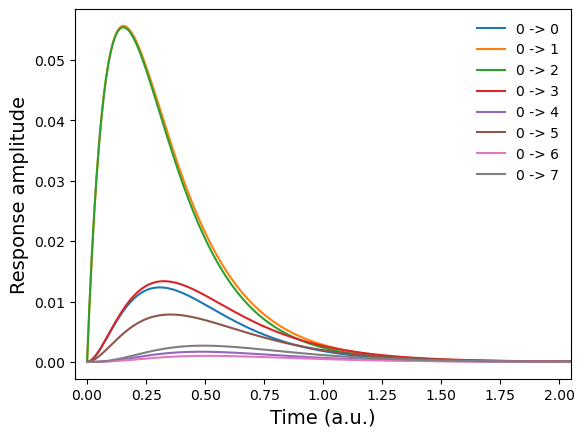

In [72]:
# Visualise the temporal evolution of the responses from i=1 to all other nodes
plt.figure()
for j in range(N):
    plt.plot(tpoints, resps[:,0,j], label='0 -> %d' %j)
plt.xlim(-0.05,2.05)
plt.xlabel('Time (a.u.)');
plt.ylabel('Response amplitude')
plt.legend(frameon=False)

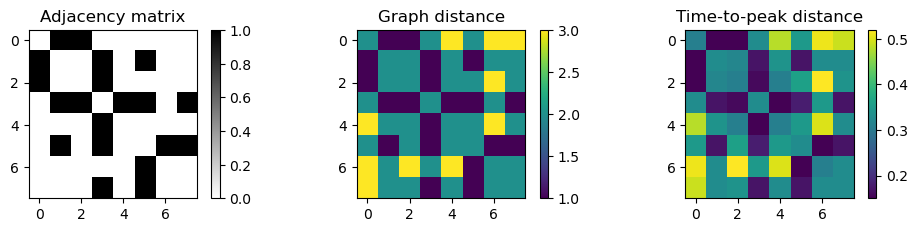

In [71]:
# Compute the classical graph distance
dij = galib.FloydWarshall(net)

# Compute the time-to-peak distance
ttpdist = rna.Time2Peak(resps, timestep=dt)

plt.figure(figsize=(10,2.4))
# Plot the adjacency matrix
plt.subplot(1,3,1)
plt.title('Adjacency matrix')
plt.imshow(net, cmap='gray_r')
plt.colorbar()

# Plot the classical graph distance
plt.subplot(1,3,2)
plt.title('Graph distance')
plt.imshow(dij)
plt.colorbar()

# Plot the time-2-peak distance matrix
plt.subplot(1,3,3)
plt.title('Time-to-peak distance')
plt.imshow(ttpdist)
plt.colorbar()

plt.tight_layout()

As seen, pairs of nodes connected by a direct links are also the ones at shortest time-to-peak. Also, both graph and time-to-peak distance matrices are rather similar since, in this case the sample graph is binary.

<br>

### Comparing distances in common graph models
We now validate the relation between classical graph distance and time-to-peak (for binary networks) in three popular graph models: random graphs (uniform probability), scale-free-like networks and ring lattices. We will

1. Generate some random, scale-free and regular networks.
2. Elucidate on the choice of a time-constant.
3. Define a new metric of distance for networks.
4. Compare the two distance measures.

We begin by creating one graph of each of the three models.

In [73]:
# Set the size, density and number of links for the networks
N = 100
dens = 0.1
L = int( round(0.5*dens*N*(N-1)))

# Generate the networks. They all have same number of links
randnet = galib.models.RandomGraph(N,L, directed=False)
sfnet = galib.models.ScaleFreeGraph(N,L, exponent=2.5, directed=False)
ringnet = galib.models.Lattice1D_FixLinks(N,L)

# Calculate their spectral radii
# For the random graph 
evs = numpy.linalg.eigvals(randnet)
evsnorms = zeros(N, float)
for i in range(N):
    evsnorms[i] = numpy.linalg.norm(evs[i])
evmax_rand = evsnorms.max()
maxtau_rand = 1./evmax_rand

# For the scale-free graph
evs = numpy.linalg.eigvals(sfnet)
evsnorms = zeros(N, float)
for i in range(N):
    evsnorms[i] = numpy.linalg.norm(evs[i])
evmax_sf = evsnorms.max()
maxtau_sf = 1./evmax_sf

# For the ring lattice 
evs = numpy.linalg.eigvals(ringnet)
evsnorms = zeros(N, float)
for i in range(N):
    evsnorms[i] = numpy.linalg.norm(evs[i])
evmax_ring = evsnorms.max()
maxtau_ring = 1./evmax_ring


print( 'RANDOM:     λmax = %3.5f  τmax = %3.5f' %(evmax_rand, maxtau_rand) )
print( 'SCALE-FREE: λmax = %3.5f  τmax = %3.5f' %(evmax_sf, maxtau_sf) )
print( 'RING LATT:  λmax = %3.5f  τmax = %3.5f' %(evmax_ring, maxtau_ring) )

RANDOM:     λmax = 10.72672  τmax = 0.09323
SCALE-FREE: λmax = 13.80974  τmax = 0.07241
RING LATT:  λmax = 9.95968  τmax = 0.10040


In [98]:
# Set a time-constant
tau_rand = 0.4 * maxtau_rand
tau_sf = 0.4 * maxtau_sf
tau_ring = 0.4 * maxtau_ring

# Define the temporal resolution
tfinal = 1.0
dt = 0.001
tpoints = arange(0.0, tfinal+dt, dt)
nsteps = len(tpoints)

# Calculate the evolution of the pair-wise responses, for the three models
resps_rand = rna.Resp_LeakyCascade(randnet, S0=1.0, tau=tau_rand, tmax=tfinal, timestep=dt, case='regressed')
resps_sf   = rna.Resp_LeakyCascade(sfnet,   S0=1.0, tau=tau_sf,   tmax=tfinal, timestep=dt, case='regressed')
resps_ring = rna.Resp_LeakyCascade(ringnet, S0=1.0, tau=tau_ring, tmax=tfinal, timestep=dt, case='regressed')

Plot the global network responses in the three cases

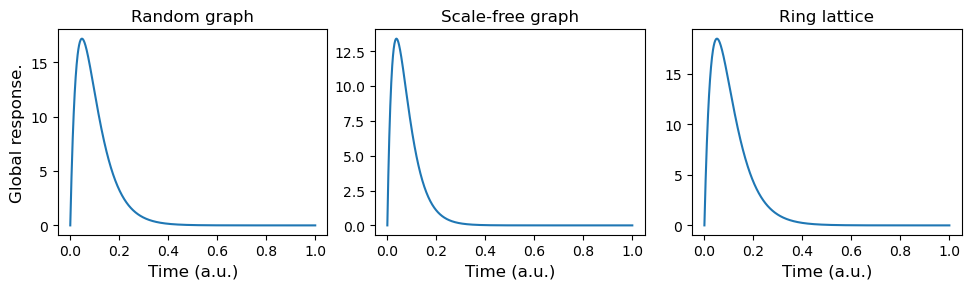

In [99]:
# Calculate the total communicability over time for the three networks
# Results 'totcom' are 1D numpy arrays of length nsteps
totresp_rand = rna.GlobalResponse(resps_rand)
totresp_sf =   rna.GlobalResponse(resps_sf)
totresp_ring = rna.GlobalResponse(resps_ring)

# Plot the results
plt.figure(figsize=(10,3))
# For the random graph
plt.subplot(1,3,1)
plt.title('Random graph', fontsize=12)
plt.plot(tpoints,totresp_rand)
#plt.ylim(-0.5,8)
plt.ylabel('Global response.', fontsize=12)
plt.xlabel('Time (a.u.)', fontsize=12)

# For the scale-free graph
plt.subplot(1,3,2)
plt.title('Scale-free graph', fontsize=12)
plt.plot(tpoints,totresp_sf)
#plt.ylim(-0.5,8)
#plt.ylabel('Total Communic.', fontsize=12)
plt.xlabel('Time (a.u.)', fontsize=12)

# For the ring lattice
plt.subplot(1,3,3)
plt.title('Ring lattice', fontsize=12)
plt.plot(tpoints,totresp_ring)
#plt.ylim(-0.5,8)
#plt.ylabel('Total Communic.', fontsize=12)
plt.xlabel('Time (a.u.)', fontsize=12)


plt.tight_layout()
#plt.show()



In [100]:
# Calculate the usual graph distance matrices for the three networks
dij_rand = galib.FloydWarshall(randnet)
dij_sf = galib.FloydWarshall(sfnet)
dij_ring = galib.FloydWarshall(ringnet)

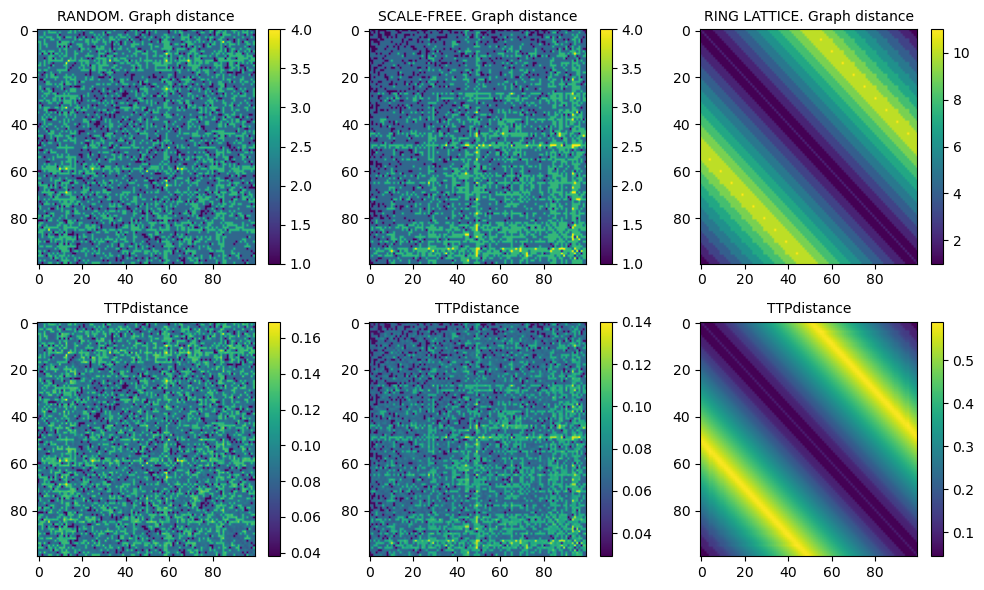

In [101]:
# Calculate now the TTPdistance for the three networks
ttpdist_rand = rna.Time2Peak(resps_rand, dt)
ttpdist_sf =   rna.Time2Peak(resps_sf, dt)
ttpdist_ring = rna.Time2Peak(resps_ring, dt)


# Plot the classical graph distances
plt.figure(figsize=(10,6))
# Random graphs
plt.subplot(2,3,1)
plt.title('RANDOM. Graph distance', fontsize=10)
plt.imshow(dij_rand, aspect='auto')
plt.colorbar()

plt.subplot(2,3,4)
plt.title('TTPdistance', fontsize=10)
plt.imshow(ttpdist_rand, aspect='auto')
plt.colorbar()

# Scale-free graphs
plt.subplot(2,3,2)

plt.title('SCALE-FREE. Graph distance', fontsize=10)
plt.imshow(dij_sf, aspect='auto')
plt.colorbar()

plt.subplot(2,3,5)
plt.title('TTPdistance', fontsize=10)
plt.imshow(ttpdist_sf, aspect='auto')
plt.colorbar()

# Ring-lattices
plt.subplot(2,3,3)
plt.title('RING LATTICE. Graph distance', fontsize=10)
plt.imshow(dij_ring, aspect='auto')
plt.colorbar()

plt.subplot(2,3,6)
plt.title('TTPdistance', fontsize=10)
plt.imshow(ttpdist_ring, aspect='auto')
plt.colorbar()

plt.tight_layout()
#plt.show()

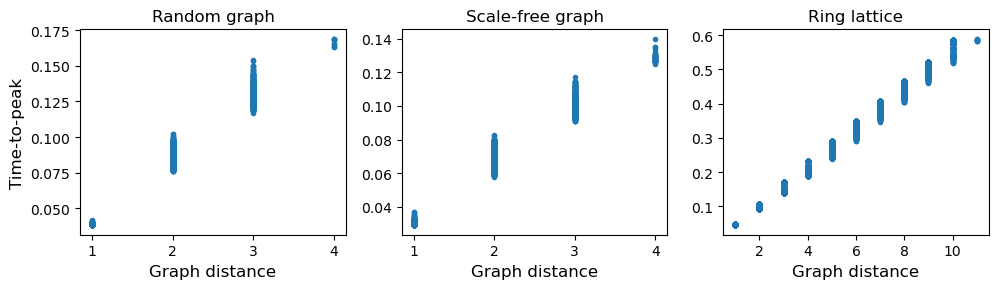

In [106]:
# Compare the pair-wise distances
# Consider only the upper triangular elements
triuidx = np.triu_indices(N,k=1)

plt.figure(figsize=(10,3))
# Relation for random graphs
plt.subplot(1,3,1)
plt.title('Random graph', fontsize=12)
plt.plot(dij_rand[triuidx], ttpdist_rand[triuidx], '.')
plt.xlabel('Graph distance', fontsize=12)
plt.ylabel('Time-to-peak', fontsize=12)

# Relation for scale-free graphs
plt.subplot(1,3,2)
plt.title('Scale-free graph', fontsize=12)
plt.plot(dij_sf[triuidx], ttpdist_sf[triuidx], '.')
plt.xlabel('Graph distance', fontsize=12)
#plt.ylabel('Time-to-peak', fontsize=12)

# Relation for ring-lattices graphs
plt.subplot(1,3,3)
plt.title('Ring lattice', fontsize=12)
plt.plot(dij_ring[triuidx], ttpdist_ring[triuidx], '.')
plt.xlabel('Graph distance', fontsize=12)
#plt.ylabel('Time-to-peak', fontsize=12)

plt.tight_layout()
#plt.show()

